In [1]:
from fact.io import read_h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
test = read_h5py("data/gamma_test_dl3.hdf5", key="events")
crab = read_h5py("data/open_crab_sample_dl3.hdf5", key="events")
crab_runs = read_h5py("data/open_crab_sample_dl3.hdf5", key="runs")

gamma_test = test["gamma_prediction"] >= 0.8
gamma_crab = crab["gamma_prediction"] >= 0.8

In [3]:
# Import and square angle theta of on- and off-positions from dataframe (all off positions flattened to one array)
theta2_s = crab["theta_deg"][gamma_crab].to_numpy()**2
theta2_bg = crab[["theta_deg_off_1","theta_deg_off_2","theta_deg_off_3","theta_deg_off_4","theta_deg_off_5"]][gamma_crab].to_numpy().flatten()**2

# Create histograms for on- and off-positions 
hist_s, bins_s = np.histogram(theta2_s[theta2_s<=np.sqrt(0.025)], bins=20)
hist_bg, bins_bg = np.histogram(theta2_bg[theta2_bg<=np.sqrt(0.025)], bins=20)

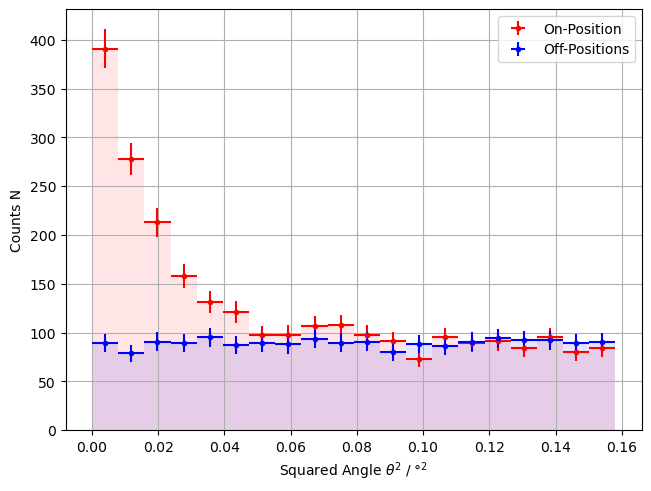

In [4]:
fig, ax = plt.subplots(constrained_layout=True)

x = bins_s[:-1] + np.diff(bins_s)/2

ax.stairs(hist_s,bins_s,fill="True",alpha=0.1,color="r")
ax.errorbar(x,hist_s,yerr=np.sqrt(hist_s),xerr=np.diff(bins_s)/2,fmt="r.",label="On-Position")
ax.stairs(hist_bg/5,bins_bg,fill="True",alpha=0.1,color="b") # divided by 5 due to 5 off positions -> average over off-positions
ax.errorbar(x,hist_bg/5,yerr=np.sqrt(hist_bg/5),xerr=np.diff(bins_bg)/2,fmt="b.",label="Off-Positions")

ax.set_xlabel(r"Squared Angle $\theta^2 \;/ \; \degree^2$")
ax.set_ylabel(r"Counts N")
ax.grid()
ax.legend(loc="best")
plt.show()

In [5]:
# Calculate Number of On- and Off-Events for theta^2 cut of 0.025 
N_on = len(theta2_s[theta2_s<=np.sqrt(0.025)])
N_off = len(theta2_bg[theta2_bg<=np.sqrt(0.025)])

# Alpha is size-factor of on- to off-region
alpha = 0.2

# Calculate significance with Likelihood-Ratio-Test due to Li & Ma
S = np.sqrt(2) * np.sqrt(N_on * np.log( (1+alpha)/alpha * N_on/(N_on + N_off)) + N_off * np.log((1+alpha) * N_off/(N_on + N_off)))
print(S)

15.989754417879428


In [6]:
# Import measured and true energies of events from dataframe
gamma_test = np.logical_and(test["gamma_prediction"] >= 0.8, test["theta_deg"]**2 <= np.sqrt(0.025))
bg_test = test[["theta_deg_off_1","theta_deg_off_2","theta_deg_off_3","theta_deg_off_4","theta_deg_off_5"]].to_numpy()**2 <= np.sqrt(0.025)
mask = np.any(bg_test,axis=1)
mask_bg = np.logical_and(mask,test["gamma_prediction"] >= 0.8)


E_pred = test["gamma_energy_prediction"][test["gamma_prediction"] >= 0.8].to_numpy()
print(len(E_pred))
E_bg_test = test["gamma_energy_prediction"][mask_bg].to_numpy()
#E_pred = np.append(E_pred,E_bg_test)

E_true = test["corsika_event_header_total_energy"][test["gamma_prediction"] >= 0.8].to_numpy()
print(len(E_true))
E_bg_true = test["corsika_event_header_total_energy"][mask_bg].to_numpy()
#E_true = np.append(E_true,E_bg_test)

# Create logarithmic bin edges for histograms
bins_true=np.logspace(np.log10(500),np.log10(15000),6)
bins_pred=np.logspace(np.log10(500),np.log10(15000),11)

# Add under-/overflow bins if necessary
if np.any(E_true<500): 
    bins_true = np.append(0,bins_true)
if np.any(E_true>15000): 
    bins_true = np.append(bins_true,np.inf)
if np.any(E_pred<500): 
    bins_pred = np.append(0,bins_pred)
if np.any(E_pred>15000): 
    bins_pred = np.append(bins_pred,np.inf)

    
print(len(E_true),len(E_pred))
# Create histograms of measured and true data
hist_E_true, bins_E_true = np.histogram(E_true, bins_true)
hist_E_pred, bins_E_pred = np.histogram(E_pred, bins_pred)

214626
214626
214626 214626


In [7]:
# Calculate energy migration matrix as 2D-histogram of measured and true data
A, _, _ = np.histogram2d(E_pred, E_true, bins=[bins_pred, bins_true])


# Normalize A
A = A/np.sum(A,axis=0)
print(np.sum(A,axis=0)) # Check if normalized: should all be 1


# Check if forward folding with A gives the same histogram as measured data (hist_E_pred)
g = A@hist_E_true


# Naive SVD Unfolding
A_inv = np.linalg.pinv(A,rcond=0)

f = A_inv@hist_E_pred


# Log-Likelihood Unfolding
def loglikelihood(f,g,b):
    L_poisson = np.empty(len(g))
    for i in range(len(g)):
        L_poisson[i] = -g[i] * np.log(A @ f + b)[i] + (A@f + b)[i]
    L_poisson = L_poisson.sum()
    return L_poisson

def loglikelihood_jac(f,g,b):
    L_poisson = np.empty(len(f))
    
    for i in range(len(f)):
        L_poisson[i] = -g @ (A[:,i] / ((A @ f) + b)) + A[:,i].sum()
        
    return L_poisson

        
x0=10000*np.ones(len(f))
x0 ,_ = np.histogram(E_pred,bins_true)

#min_l_test = minimize(loglikelihood,x0,args=(hist_E_pred),method="BFGS",jac=loglikelihood_jac)
#err_test = np.sqrt(np.diag(min_l_test.hess_inv))

[1. 1. 1. 1. 1. 1. 1.]


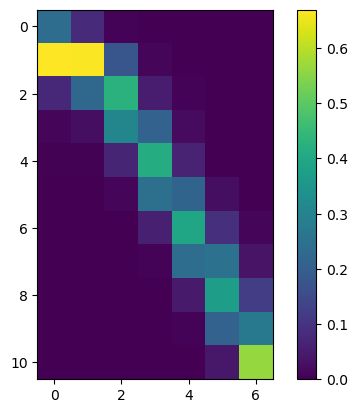

In [8]:
plt.imshow(A)
plt.colorbar()
plt.show()

/home/Luca/.local/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3458: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


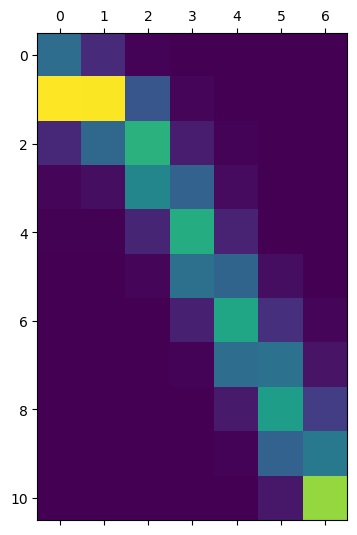

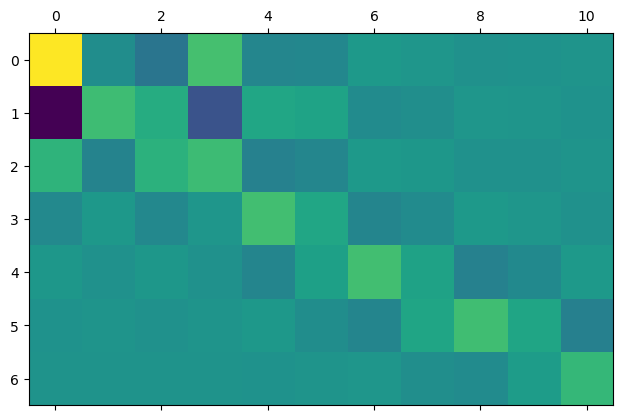

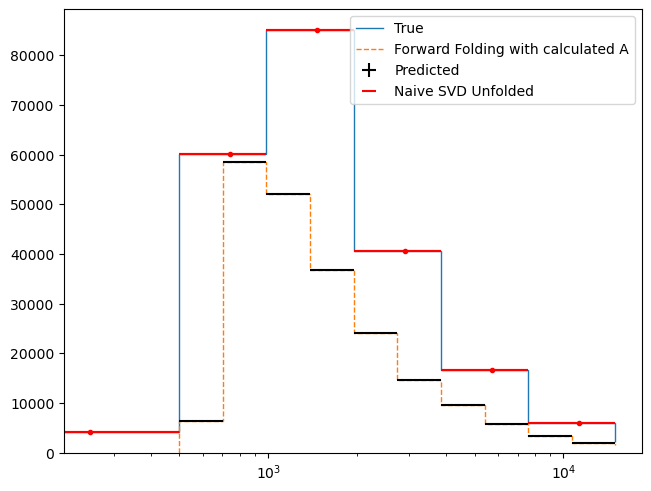

In [9]:
# OBSOLET FÜR DAS PROTOKOLL
#
#

plt.matshow(A)
plt.matshow(A_inv)

fig, ax = plt.subplots(constrained_layout=True)
x_true = bins_E_true[:-1] + np.diff(bins_E_true)/2
x_pred = bins_E_pred[:-1] + np.diff(bins_E_pred)/2
width_pred = np.diff(bins_E_pred)/2
width_true = np.diff(bins_E_true)/2

ax.stairs(hist_E_true,bins_E_true,label="True")
ax.errorbar(x_true, hist_E_true, xerr=width_true, fmt="r.")
ax.errorbar(x_pred, hist_E_pred, yerr=np.sqrt(hist_E_pred), xerr=width_pred, fmt="None", ecolor="k", label="Predicted")
ax.stairs(g,bins_E_pred,linestyle="--",label="Forward Folding with calculated A")
ax.errorbar(x_true, f, xerr=width_true, fmt="None", ecolor="r", label="Naive SVD Unfolded")
#ax.errorbar(x_true, min_l_test.x, yerr=err_test, xerr=width_true, fmt="None", ecolor="b", label="log-likelihood Unfolded")

ax.set_xscale("log")
ax.legend(loc="best")

plt.show()

#
#
# OBSOLET FÜR DAS PROTOKOLL

In [10]:
# Get Crab Nebula measured Energies
gamma_crab = np.logical_and(crab["gamma_prediction"] >= 0.8, crab["theta_deg"]**2 <= np.sqrt(0.025))
bg_crab = crab[["theta_deg_off_1","theta_deg_off_2","theta_deg_off_3","theta_deg_off_4","theta_deg_off_5"]].to_numpy()**2 <= np.sqrt(0.025)
mask = np.any(bg_crab,axis=1)
mask_bg = np.logical_and(mask,crab["gamma_prediction"] >= 0.8)

E_crab = crab["gamma_energy_prediction"][gamma_crab].to_numpy()
E_bg_crab = crab["gamma_energy_prediction"][mask_bg].to_numpy()
E_tot = np.append(E_crab,E_bg_crab)

# Make energy histogram
g_crab, bins_E_crab = np.histogram(E_tot, bins_pred)
b_crab, _ = np.histogram(E_bg_crab, bins_pred)
print(g_crab)
print(b_crab)

# Naive SVD Unfolding
f_crab = A_inv@(g_crab-b_crab)


x0_g,_=np.histogram(E_tot,bins_true)
x0_b,_=np.histogram(E_bg_crab,bins_true)
x0 = x0_g - x0_b

# Poisson Likelihood Unfolding
min_l = minimize(loglikelihood,x0,args=(g_crab,b_crab),method="BFGS",jac=loglikelihood_jac)
f_like = min_l.x
err_f = np.sqrt(np.diag(min_l.hess_inv))
print(min_l)

[ 399 3328 2615 1779 1056  667  353  194   74   30   12]
[ 300 2546 1963 1347  785  493  264  141   56   22    8]
      fun: -67996.64761241723
 hess_inv: array([[ 1.44876436e+04, -1.80932178e+04,  4.81201845e+03,
        -8.65443059e+02,  1.01279485e+02, -1.96449500e+01,
         1.05365223e+00],
       [-1.80932178e+04,  3.02321634e+04, -1.07468246e+04,
         2.24972477e+03, -3.89333552e+02,  6.31523878e+01,
        -7.31052697e+00],
       [ 4.81201845e+03, -1.07468246e+04,  1.25305005e+04,
        -3.37014609e+03,  6.45102167e+02, -1.01385272e+02,
         1.32429650e+01],
       [-8.65443059e+02,  2.24972477e+03, -3.37014609e+03,
         4.94834898e+03, -1.23391108e+03,  2.09033059e+02,
        -2.52131921e+01],
       [ 1.01279485e+02, -3.89333552e+02,  6.45102167e+02,
        -1.23391108e+03,  1.65863022e+03, -3.58254644e+02,
         4.30694028e+01],
       [-1.96449500e+01,  6.31523878e+01, -1.01385272e+02,
         2.09033059e+02, -3.58254644e+02,  3.76956393e+02,
       

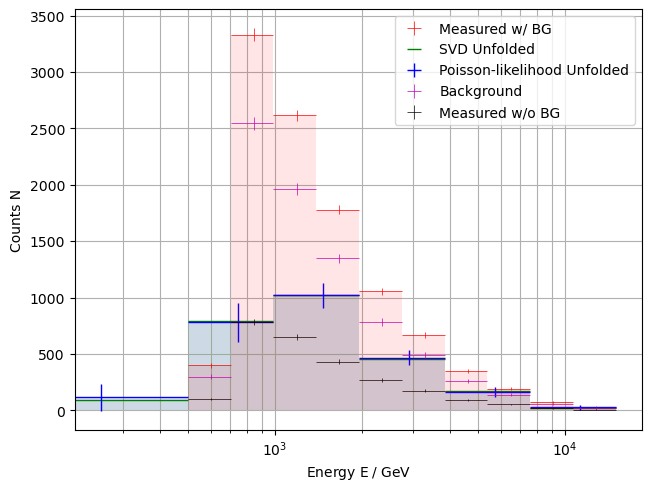

In [11]:
fig, ax = plt.subplots(constrained_layout=True)

x_crab = bins_E_crab[:-1] + np.diff(bins_E_crab)/2

ax.stairs(g_crab[:-1], bins_E_crab[:-1], color="r",linewidth="0.5", zorder=3 ,fill="True",alpha=0.1)
ax.errorbar(x_crab, g_crab, xerr=width_pred, yerr=np.sqrt(g_crab), fmt="none", ecolor="r", elinewidth=0.5, label="Measured w/ BG")
ax.stairs(f_crab[:-1], bins_E_true[:-1], color="g",linewidth="0.5", zorder=2,fill="True",alpha=0.1)
ax.errorbar(x_true, f_crab, xerr=width_true, fmt="None", ecolor="g", elinewidth=1, label="SVD Unfolded")
ax.stairs(f_like[:-1], bins_E_true[:-1], color="b",linewidth="0.5", zorder=1,fill="True",alpha=0.1)
ax.errorbar(x_true, f_like, xerr=width_true, yerr=err_f, fmt="none", ecolor="b", elinewidth=1, label="Poisson-likelihood Unfolded")

ax.errorbar(x_crab, b_crab, xerr=width_pred, yerr=np.sqrt(g_crab), fmt="none", ecolor="m", elinewidth=0.5, label="Background")
ax.errorbar(x_crab, g_crab-b_crab, xerr=width_pred, yerr=np.sqrt(g_crab-b_crab), fmt="none", ecolor="k", elinewidth=0.5, label="Measured w/o BG")



ax.set_xlabel(r"Energy E$\;/\; $GeV")
ax.set_ylabel(r"Counts N")

ax.set_xscale("log")
ax.grid(which="both")
ax.legend(loc="best")

plt.show()

In [16]:
A_tot = np.pi*270**2
N_sel, _ = np.histogram(E_pred,bins_true[1:-1])
N_sim = hist_E_true[1:-1]
A_eff = N_sel/N_sim*0.7 * A_tot
print(A_eff/A_tot)
print(A_eff)

[0.75626778 0.73100035 0.6658759  0.65356369 0.61560201]
[173202.03746285 167415.2392104  152500.30070543 149680.53142173
 140986.46707352]


In [19]:
# Import observation time, sum
t_obs = crab_runs["ontime"].to_numpy()
t_obs = t_obs.sum()
print(t_obs)


# Calculate width of energy bins
dE = np.diff(bins_E_true)[1:-1]
print(dE)

# Calculate flux for unfolded event counts with SVD and Poisson-likelihood method
phi_crab = f_crab[1:-1] / (A_eff * dE * t_obs) 
phi_like = f_like[1:-1] / (A_eff * dE * t_obs) 
print(phi_crab,phi_like)
# Unit: GeV^-1 m^-2 s^-1 = 10 * TeV^-1 cm^-2 s^-1

63815.89405119419
[ 487.17524292  961.85467754 1899.0382499  3749.36709132 7402.56473832]
[1.47868734e-10 9.99321695e-11 2.48097214e-11 4.69479553e-12
 3.86958510e-13] [1.45329314e-10 9.92094448e-11 2.53823849e-11 4.55393452e-12
 3.98984890e-13]


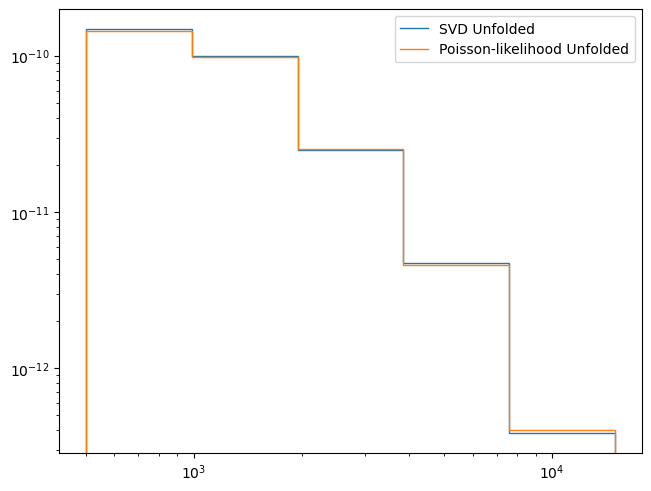

In [20]:
# OBSOLET FÜR DAS PROTOKOLL
#
#

fig, ax = plt.subplots(constrained_layout=True)

ax.stairs(phi_crab,bins_E_true[1:-1],label="SVD Unfolded")
ax.stairs(phi_like,bins_E_true[1:-1],label="Poisson-likelihood Unfolded")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

plt.show()

#
#
# OBSOLET FÜR DAS PROTOKOLL

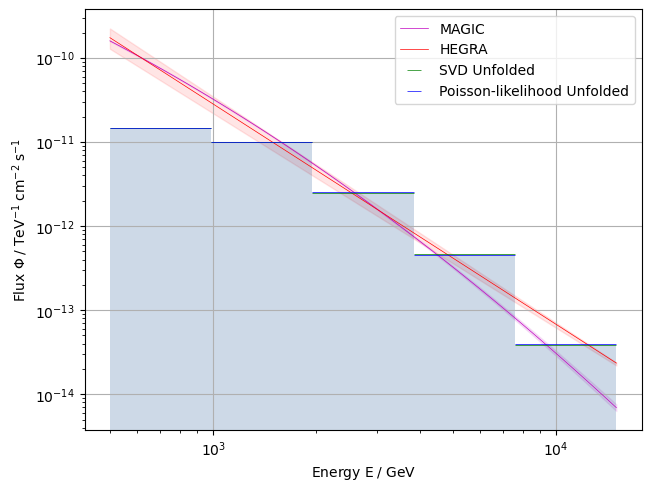

In [21]:
phi_magic = lambda E,phi0,a,b: phi0 * (E/1000) ** (a + b*np.log(E/1000))
phi_hegra = lambda E,phi0,gamma: phi0 * (E/1000) ** (gamma)

phi_magic_params = np.array([[3.23e-11,-2.47,-0.24],[3.26e-11,-2.48,-0.25],[3.2e-11,-2.46,-0.23]])
phi_hegra_params = np.array([[2.83e-11,-2.62],[3.47e-11,-2.69],[2.19e-11,-2.55]])


E = np.logspace(np.log10(500),np.log10(15000),100)

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(E,phi_magic(E, *phi_magic_params[0]), "m-", linewidth=0.5,  label="MAGIC")
ax.fill_between(E, phi_magic(E, *phi_magic_params[2]), phi_magic(E,*phi_magic_params[1]), color="m", alpha=0.1)
ax.plot(E,phi_hegra(E, *phi_hegra_params[0]), "r-", linewidth=0.5, label="HEGRA")
ax.fill_between(E, phi_hegra(E,*phi_hegra_params[2]), phi_hegra(E,*phi_hegra_params[1]), color="r", alpha=0.1)


ax.stairs(phi_crab/10, bins_E_true[1:-1], color="g",linewidth=0.5, fill="True", alpha=0.1)
ax.errorbar(x_true[1:-1], phi_crab/10, xerr=width_true[1:-1], fmt="none", ecolor="g", elinewidth=0.5, label="SVD Unfolded")
ax.stairs(phi_like/10, bins_E_true[1:-1], color="b",linewidth=0.5, fill="True", alpha=0.1)
ax.errorbar(x_true[1:-1], phi_like/10, xerr=width_true[1:-1], fmt="none", ecolor="b", elinewidth=0.5, label="Poisson-likelihood Unfolded")

ax.set_xlabel(r"Energy E$\;/\; $GeV")
ax.set_ylabel(r"Flux $\Phi \;/\; $TeV$^{-1}\; $cm$^{-2}\; $s$^{-1}$")

ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")

plt.show()